In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
from PIL import Image
import numpy as np

from torch.utils.data import Dataset


class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, image_dirs, ann_dirs, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
        """
        self.image_dirs = image_dirs
        self.ann_dirs = label_dirs
        self.images = []
        self.annotations = []

        self.feature_extractor = feature_extractor

        # self.img_dir = os.path.join(self.root_dir, "images")
        # self.ann_dir = os.path.join(self.root_dir, "annotations")

        # read images
        # for test dataset, we won't provide the labels
        if ann_dirs:
              for image_dir, label_dir in zip(image_dirs, ann_dirs):

                  image_files = sorted(os.listdir(image_dir))
                  ann_files = sorted(os.listdir(label_dir))

                  image_files_no_ext = [os.path.splitext(f)[0] for f in image_files]
                  label_files_no_ext = [os.path.splitext(f)[0] for f in ann_files]

                  matched_files = set(image_files_no_ext).intersection(set(label_files_no_ext))

                  for file in matched_files:
                      self.images.append(os.path.join(image_dir, file + '.png'))  # Assuming image files are .jpg
                      self.annotations.append(os.path.join(label_dir, file + '.png'))  # Assuming label files are .png
        else:
              for image_dir in image_dirs:
                  images = sorted(os.listdir(image_dir))
                  self.images.extend([os.path.join(image_dir, img) for img in images])

        print(self.images)
        print("labels \n", self.annotations)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')  # Ensure image is in RGB format
        annotation = Image.open(self.annotations[idx]).convert('RGB')  # Ensure annotation is in RGB format

        # make 2D segmentation map (based on 3D one)
        # thanks a lot, Stackoverflow: https://stackoverflow.com/questions/61897492/finding-the-number-of-pixels-in-a-numpy-array-equal-to-a-given-color
        annotation = np.array(annotation)
        annotation_2d = np.zeros((annotation.shape[0], annotation.shape[1]), dtype=np.uint8) # height, width

        for id, color in id2color.items():
            annotation_2d[(annotation == color).all(axis=-1)] = id

        # randomly crop + pad both image and segmentation map to same size
        # feature extractor will also reduce labels!
        encoded_inputs = self.feature_extractor(image, Image.fromarray(annotation_2d), return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [3]:
import pandas as pd
import json

# Read the JSON file
label_path  = '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/labels.json'
import pandas as pd
import json

# Read the JSON file
with open(label_path, 'r') as f:
    data = json.load(f)

# Normalize the JSON data
# Normalize the JSON data
df = pd.json_normalize(data)

# Extract the 'color' column into separate 'R', 'G', and 'B' columns
colors = pd.DataFrame(df['color'].tolist(), columns=['R', 'G', 'B'])

# Concatenate the extracted columns with the original DataFrame
df = pd.concat([df, colors], axis=1)

# Drop the original 'color' column
df = df.drop(columns=['color'])

# Rename columns to match the expected structure
df = df.rename(columns={'name': 'label', 'classid': 'label_idx'})

# Reorder columns to match the desired structure
df = df[['label_idx', 'label', 'R', 'G', 'B']]

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Display the DataFrame
print(df)


    label_idx               label    R    G    B
0           0   background-tissue    0    0    0
1           1    instrument-shaft    0  255    0
2           2  instrument-clasper    0  255  255
3           3    instrument-wrist  125  255   12
4           4   kidney-parenchyma  255   55    0
5           5      covered-kidney   24   55  125
6           6              thread  187  155   25
7           7              clamps    0  255  125
8           8     suturing-needle  255  255  125
9           9  suction-instrument  123   15  175
10         10     small-intestine  124  155    5


In [4]:
label2id = {label: id for id, label in enumerate(df.label)}
id2label = {id: label for id, label in enumerate(df.label)}
print(id2label)
print(label2id)

{0: 'background-tissue', 1: 'instrument-shaft', 2: 'instrument-clasper', 3: 'instrument-wrist', 4: 'kidney-parenchyma', 5: 'covered-kidney', 6: 'thread', 7: 'clamps', 8: 'suturing-needle', 9: 'suction-instrument', 10: 'small-intestine'}
{'background-tissue': 0, 'instrument-shaft': 1, 'instrument-clasper': 2, 'instrument-wrist': 3, 'kidney-parenchyma': 4, 'covered-kidney': 5, 'thread': 6, 'clamps': 7, 'suturing-needle': 8, 'suction-instrument': 9, 'small-intestine': 10}


In [5]:
len(id2label)

11

In [6]:
id2color = {id: [R,G,B] for id, (R,G,B) in enumerate(zip(df.R, df.G, df.B))}
print(id2color)

{0: [0, 0, 0], 1: [0, 255, 0], 2: [0, 255, 255], 3: [125, 255, 12], 4: [255, 55, 0], 5: [24, 55, 125], 6: [187, 155, 25], 7: [0, 255, 125], 8: [255, 255, 125], 9: [123, 15, 175], 10: [124, 155, 5]}


In [7]:
id2color[label2id["background-tissue"]]

[0, 0, 0]

# Initialize the training dataset

In [8]:
image_dirs = ["/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames", "/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_2/left_frames", "/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_3/left_frames"]
label_dirs = ["/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/labels", "/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_2/labels", "/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_3/labels"]


In [9]:
from transformers import SegformerFeatureExtractor

root_dir = '/content/drive/MyDrive/SegFormer/Notebooks/Tutorial notebooks/RUGD/RUGD_sample-data'

# we want to include our 0th label
feature_extractor = SegformerFeatureExtractor(reduce_labels=False)


train_dataset = SemanticSegmentationDataset(image_dirs=image_dirs, ann_dirs=label_dirs, feature_extractor=feature_extractor)

['/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame060.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame077.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame115.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame046.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame062.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame028.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame134.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame022.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame146.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame076.png', '/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame041.png', '/content

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [10]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 447


In [11]:
encoded_inputs = train_dataset[0]

In [12]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [13]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [14]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 2, 2,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [15]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 0,  1,  2,  4,  6,  7, 10])

# Lets define a dataloader

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [17]:
batch = next(iter(train_dataloader))

In [18]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [19]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [20]:
mask = (batch["labels"] != 255)
mask

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [21]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 0, 0, 0])

# Define the model

In [22]:
# del id2color[0]

id2color = {id: color for id, color in id2color.items()}
print(id2color)

{0: [0, 0, 0], 1: [0, 255, 0], 2: [0, 255, 255], 3: [125, 255, 12], 4: [255, 55, 0], 5: [24, 55, 125], 6: [187, 155, 25], 7: [0, 255, 125], 8: [255, 255, 125], 9: [123, 15, 175], 10: [124, 155, 5]}


In [23]:
# del id2label[0]

label2id = {label: id for id, label in id2label.items()}
id2label = {id: label for id, label in id2label.items()}
print(id2label)

{0: 'background-tissue', 1: 'instrument-shaft', 2: 'instrument-clasper', 3: 'instrument-wrist', 4: 'kidney-parenchyma', 5: 'covered-kidney', 6: 'thread', 7: 'clamps', 8: 'suturing-needle', 9: 'suction-instrument', 10: 'small-intestine'}


In [24]:
from transformers import SegformerForSemanticSegmentation

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=11,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.li

# Fine tune the model

In [25]:
# !pip install datasets

In [26]:
from datasets import load_metric

metric = load_metric("mean_iou")

<ipython-input-26-7fa4e6e26caa>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for mean_iou contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/mean_iou/mean_iou.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [29]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(10):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx:
          # we use _compute for now which fixes an issue in speed
          # see this Github thread for more info:
          metrics = metric.compute(num_labels=len(id2label),
                                   ignore_index=255,
                                   reduce_labels=False)

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/224 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 2.3239026069641113
Mean_iou: 0.054584968031652914
Mean accuracy: 0.13035629656194253
Loss: 2.211672306060791
Mean_iou: 0.1089276328428817
Mean accuracy: 0.33218275470969216
Loss: 2.196605682373047
Mean_iou: 0.10197650089356582
Mean accuracy: 0.2730501756116136
Loss: 2.1592512130737305
Mean_iou: 0.14396850756300414
Mean accuracy: 0.26674006454331667
Loss: 2.2142953872680664
Mean_iou: 0.06867029880671432
Mean accuracy: 0.2531991956115515
Loss: 2.1316421031951904
Mean_iou: 0.12854388494022598
Mean accuracy: 0.33412708824313103
Loss: 2.194334030151367
Mean_iou: 0.09551250845473458
Mean accuracy: 0.2779135183952588
Loss: 2.105102777481079
Mean_iou: 0.1466812158424922
Mean accuracy: 0.4962589347360571
Loss: 2.1221985816955566
Mean_iou: 0.14244571311124127
Mean accuracy: 0.3666229379498688
Loss: 2.1168200969696045
Mean_iou: 0.11423525605622982
Mean accuracy: 0.35342723292843714
Loss: 2.0234851837158203
Mean_iou: 0.16784448918829226
Mean accuracy: 0.4294246998082987
Loss: 2.1048815250396

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


Loss: 1.8538182973861694
Mean_iou: 0.21441812579003566
Mean accuracy: 0.5086877095996646
Loss: 1.7949222326278687
Mean_iou: 0.2206047648260959
Mean accuracy: 0.46824730997608593
Loss: 1.850260853767395
Mean_iou: 0.14602268415095215
Mean accuracy: 0.35812471417026404
Loss: 1.7210274934768677
Mean_iou: 0.1946741645440175
Mean accuracy: 0.4191420664439819
Loss: 1.8471204042434692
Mean_iou: 0.25457024040232057
Mean accuracy: 0.44304442674898037
Loss: 1.850297451019287
Mean_iou: 0.2328430939135455
Mean accuracy: 0.498691029533816
Loss: 1.790205717086792
Mean_iou: 0.17819804381936574
Mean accuracy: 0.47192969892361347
Loss: 1.8099747896194458
Mean_iou: 0.1623567508763965
Mean accuracy: 0.48481169941821706
Loss: 1.586100459098816
Mean_iou: 0.28209639762808186
Mean accuracy: 0.4390520138614739
Loss: 1.5421733856201172
Mean_iou: 0.2759808006568002
Mean accuracy: 0.5312458946697376
Loss: 1.6119821071624756
Mean_iou: 0.2648261373163031
Mean accuracy: 0.5440551451917922
Loss: 1.730319857597351
Mea

  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.7325389385223389
Mean_iou: 0.4568685685416934
Mean accuracy: 0.5731908555220424
Loss: 0.5096327662467957
Mean_iou: 0.46725635733806903
Mean accuracy: 0.5645793683908641
Loss: 0.7694262862205505
Mean_iou: 0.47653125271547075
Mean accuracy: 0.614751926499347
Loss: 0.5764914751052856
Mean_iou: 0.5036828947254197
Mean accuracy: 0.6621613469054601
Loss: 0.5923023223876953
Mean_iou: 0.5235645567914121
Mean accuracy: 0.5958929322686716
Loss: 0.491726279258728
Mean_iou: 0.557738627161898
Mean accuracy: 0.6328580580902984
Loss: 0.5875706672668457
Mean_iou: 0.5986135091137832
Mean accuracy: 0.7162306073597939
Loss: 0.5142484903335571
Mean_iou: 0.5662875322101135
Mean accuracy: 0.6759104385855503
Loss: 0.43033266067504883
Mean_iou: 0.6315597672503573
Mean accuracy: 0.7251438650521976
Loss: 0.7128372192382812
Mean_iou: 0.4233297729661714
Mean accuracy: 0.5902413594647581
Loss: 0.6531414985656738
Mean_iou: 0.5097983328946897
Mean accuracy: 0.6501159968306058
Loss: 0.7901703119277954
Mean_io

  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.3180057108402252
Mean_iou: 0.5808316947821781
Mean accuracy: 0.665393109004032
Loss: 0.42490509152412415
Mean_iou: 0.5385652260924695
Mean accuracy: 0.615602500764788
Loss: 0.3801535964012146
Mean_iou: 0.6646127814484234
Mean accuracy: 0.9153261398777378
Loss: 0.37509334087371826
Mean_iou: 0.49408885342073067
Mean accuracy: 0.5713854632347103
Loss: 0.3747551441192627
Mean_iou: 0.6016339835950244
Mean accuracy: 0.736006767971845
Loss: 0.3742760121822357
Mean_iou: 0.5613014047196229
Mean accuracy: 0.6727057968359731
Loss: 0.517996072769165
Mean_iou: 0.5500981024573357
Mean accuracy: 0.7098791462024076
Loss: 0.36258208751678467
Mean_iou: 0.5400526842110572
Mean accuracy: 0.6727704792721425
Loss: 0.40814459323883057
Mean_iou: 0.5409684811961346
Mean accuracy: 0.7674100771891338
Loss: 0.44471094012260437
Mean_iou: 0.6664093473961746
Mean accuracy: 0.7883109888906887
Loss: 0.24014407396316528
Mean_iou: 0.7018535731072806
Mean accuracy: 0.7744241712875661
Loss: 0.3920377194881439
Mean

  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.2565513253211975
Mean_iou: 0.7579214502047048
Mean accuracy: 0.8554448538332782
Loss: 0.21817472577095032
Mean_iou: 0.6461763571903367
Mean accuracy: 0.728254006261353
Loss: 0.3176374137401581
Mean_iou: 0.6392507845703652
Mean accuracy: 0.7312450877959603
Loss: 0.4235221743583679
Mean_iou: 0.5794691448384797
Mean accuracy: 0.842444505458974
Loss: 0.24539920687675476
Mean_iou: 0.7027469973957373
Mean accuracy: 0.7791605280644477
Loss: 0.302801251411438
Mean_iou: 0.6746595483174201
Mean accuracy: 0.7546187300621867
Loss: 0.18630290031433105
Mean_iou: 0.719647158784838
Mean accuracy: 0.8123570391034619
Loss: 0.23004436492919922
Mean_iou: 0.6494386993711497
Mean accuracy: 0.7432622284794053
Loss: 0.22672778367996216
Mean_iou: 0.8009667028595894
Mean accuracy: 0.9243482278208981
Loss: 0.24892078340053558
Mean_iou: 0.6423024945758531
Mean accuracy: 0.7671917225818969
Loss: 0.3049585521221161
Mean_iou: 0.6082200498171582
Mean accuracy: 0.6553025548900612
Loss: 0.22748003900051117
Mean

  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.21102702617645264
Mean_iou: 0.6364925960130079
Mean accuracy: 0.7371968385116245
Loss: 0.2443772256374359
Mean_iou: 0.7245218838912024
Mean accuracy: 0.7912855913091735
Loss: 0.13441845774650574
Mean_iou: 0.8028206197219376
Mean accuracy: 0.8584129267586053
Loss: 0.183222696185112
Mean_iou: 0.6650735850549718
Mean accuracy: 0.8324930210278892
Loss: 0.2154204547405243
Mean_iou: 0.763274713886556
Mean accuracy: 0.8295853363219149
Loss: 0.27667123079299927
Mean_iou: 0.590631076770294
Mean accuracy: 0.6668733168471299
Loss: 0.17287084460258484
Mean_iou: 0.7328792351877843
Mean accuracy: 0.8098130127648394
Loss: 0.19248385727405548
Mean_iou: 0.8160904565984146
Mean accuracy: 0.9039923930622079
Loss: 0.2500459551811218
Mean_iou: 0.5634552363699853
Mean accuracy: 0.7117034228309896
Loss: 0.18834102153778076
Mean_iou: 0.6816391851012398
Mean accuracy: 0.7916606839612446
Loss: 0.2519546151161194
Mean_iou: 0.7326700701443235
Mean accuracy: 0.8086789613664439
Loss: 0.21403050422668457
Mea

  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.15770837664604187
Mean_iou: 0.7858396476147788
Mean accuracy: 0.8826053703599868
Loss: 0.4407665729522705
Mean_iou: 0.5488091525917693
Mean accuracy: 0.7648757109811637
Loss: 0.17686599493026733
Mean_iou: 0.742538841805471
Mean accuracy: 0.7945158159021265
Loss: 0.27791136503219604
Mean_iou: 0.6640718406124
Mean accuracy: 0.7397388567634073
Loss: 0.2122410535812378
Mean_iou: 0.7212665521021849
Mean accuracy: 0.8092488405590605
Loss: 0.26375776529312134
Mean_iou: 0.7637446657382959
Mean accuracy: 0.8262051613173388
Loss: 0.20636454224586487
Mean_iou: 0.6841664426341473
Mean accuracy: 0.7525386751179728
Loss: 0.2732652425765991
Mean_iou: 0.7579475048263346
Mean accuracy: 0.8524936016218231
Loss: 0.17643767595291138
Mean_iou: 0.6412972573529099
Mean accuracy: 0.7534845111354209
Loss: 0.20129814743995667
Mean_iou: 0.6144217486987417
Mean accuracy: 0.7870177645947115
Loss: 0.21077990531921387
Mean_iou: 0.7482293094990179
Mean accuracy: 0.8263809598080702
Loss: 0.472111314535141
Mean

  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.20370855927467346
Mean_iou: 0.787674396565379
Mean accuracy: 0.8680228266654938
Loss: 0.259927362203598
Mean_iou: 0.6835577788662661
Mean accuracy: 0.7635561575013715
Loss: 0.25032082200050354
Mean_iou: 0.6260317521969263
Mean accuracy: 0.7327511354133606
Loss: 0.16880926489830017
Mean_iou: 0.7545220371180588
Mean accuracy: 0.8641092218724413
Loss: 0.1872953325510025
Mean_iou: 0.7632208029238834
Mean accuracy: 0.9082130125241357
Loss: 0.19022978842258453
Mean_iou: 0.7217281224396153
Mean accuracy: 0.7888258962881015
Loss: 0.10881325602531433
Mean_iou: 0.7859290819568998
Mean accuracy: 0.8912397342009764
Loss: 0.19350431859493256
Mean_iou: 0.7320570302606585
Mean accuracy: 0.8846982993815077
Loss: 0.15008077025413513
Mean_iou: 0.6143204835002755
Mean accuracy: 0.7878872413110112
Loss: 0.1841731071472168
Mean_iou: 0.7587965042383099
Mean accuracy: 0.8575313236202016
Loss: 0.16947618126869202
Mean_iou: 0.7186899285148445
Mean accuracy: 0.8805727168310823
Loss: 0.14651969075202942


  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.11804596334695816
Mean_iou: 0.734217346352494
Mean accuracy: 0.8040318323418439
Loss: 0.11348510533571243
Mean_iou: 0.5484139658974354
Mean accuracy: 0.6035139094761162
Loss: 0.1558775007724762
Mean_iou: 0.8058651184468714
Mean accuracy: 0.9007870882229679
Loss: 0.11866019666194916
Mean_iou: 0.8194282908192468
Mean accuracy: 0.8982685016210703
Loss: 0.19762301445007324
Mean_iou: 0.7971559817433231
Mean accuracy: 0.8898490572717301
Loss: 0.1186276227235794
Mean_iou: 0.628713469556752
Mean accuracy: 0.9612172819449748
Loss: 0.17479008436203003
Mean_iou: 0.6960411495522746
Mean accuracy: 0.7536604626586091
Loss: 0.1480199098587036
Mean_iou: 0.7956204349628822
Mean accuracy: 0.8584893251254594
Loss: 0.17127327620983124
Mean_iou: 0.7122888542612966
Mean accuracy: 0.7854348692410047
Loss: 0.14359122514724731
Mean_iou: 0.81017820751772
Mean accuracy: 0.9052112823883979
Loss: 0.12858742475509644
Mean_iou: 0.7702686618706979
Mean accuracy: 0.8686471517276078
Loss: 0.09973082691431046
Me

  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.10348425805568695
Mean_iou: 0.7287097692790405
Mean accuracy: 0.8019597989468403
Loss: 0.20383602380752563
Mean_iou: 0.763353479872483
Mean accuracy: 0.8436393379449824
Loss: 0.13439327478408813
Mean_iou: 0.80567650665408
Mean accuracy: 0.8920681724785379
Loss: 0.14956581592559814
Mean_iou: 0.7580619558968074
Mean accuracy: 0.8511148550650309
Loss: 0.1414763331413269
Mean_iou: 0.813383867226045
Mean accuracy: 0.8907752329701104
Loss: 0.2541379928588867
Mean_iou: 0.637013130487927
Mean accuracy: 0.8190858594365716
Loss: 0.17569343745708466
Mean_iou: 0.6367236593102181
Mean accuracy: 0.749367586629273
Loss: 0.15623319149017334
Mean_iou: 0.7407911105782163
Mean accuracy: 0.8291680546308181
Loss: 0.17316269874572754
Mean_iou: 0.6788191895865234
Mean accuracy: 0.8519527454875765
Loss: 0.13772058486938477
Mean_iou: 0.8153157251620876
Mean accuracy: 0.8654229371534083
Loss: 0.15494944155216217
Mean_iou: 0.5796394386807133
Mean accuracy: 0.8092861524365208
Loss: 0.08842691779136658
Mea

  0%|          | 0/224 [00:00<?, ?it/s]

Loss: 0.11337640136480331
Mean_iou: 0.7758606904978471
Mean accuracy: 0.841357133682493
Loss: 0.16858990490436554
Mean_iou: 0.8021444865787472
Mean accuracy: 0.8675521439361683
Loss: 0.1179925799369812
Mean_iou: 0.7787091346336851
Mean accuracy: 0.8589294174164626
Loss: 0.17375141382217407
Mean_iou: 0.7917451305004034
Mean accuracy: 0.8813076036506055
Loss: 0.11082976311445236
Mean_iou: 0.8503555736174684
Mean accuracy: 0.928436439505964
Loss: 0.17602697014808655
Mean_iou: 0.7571108514943228
Mean accuracy: 0.8613230774546764
Loss: 0.11379242688417435
Mean_iou: 0.7989771351443172
Mean accuracy: 0.9198695075298952
Loss: 0.18795593082904816
Mean_iou: 0.7717131115865389
Mean accuracy: 0.8722582778398809
Loss: 0.17976364493370056
Mean_iou: 0.794931930217211
Mean accuracy: 0.8539851686598425
Loss: 0.11579212546348572
Mean_iou: 0.7740049694140076
Mean accuracy: 0.8962391020627195
Loss: 0.12653692066669464
Mean_iou: 0.7852448230497163
Mean accuracy: 0.9060827781276607
Loss: 0.10378358513116837

In [32]:
# Save the model:
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "model_checkpoint.pth")
# Save the model checkpoint every epoch
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, checkpoint_path)
# Load checkpoint if available

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
else:
    start_epoch = 0

# Inference

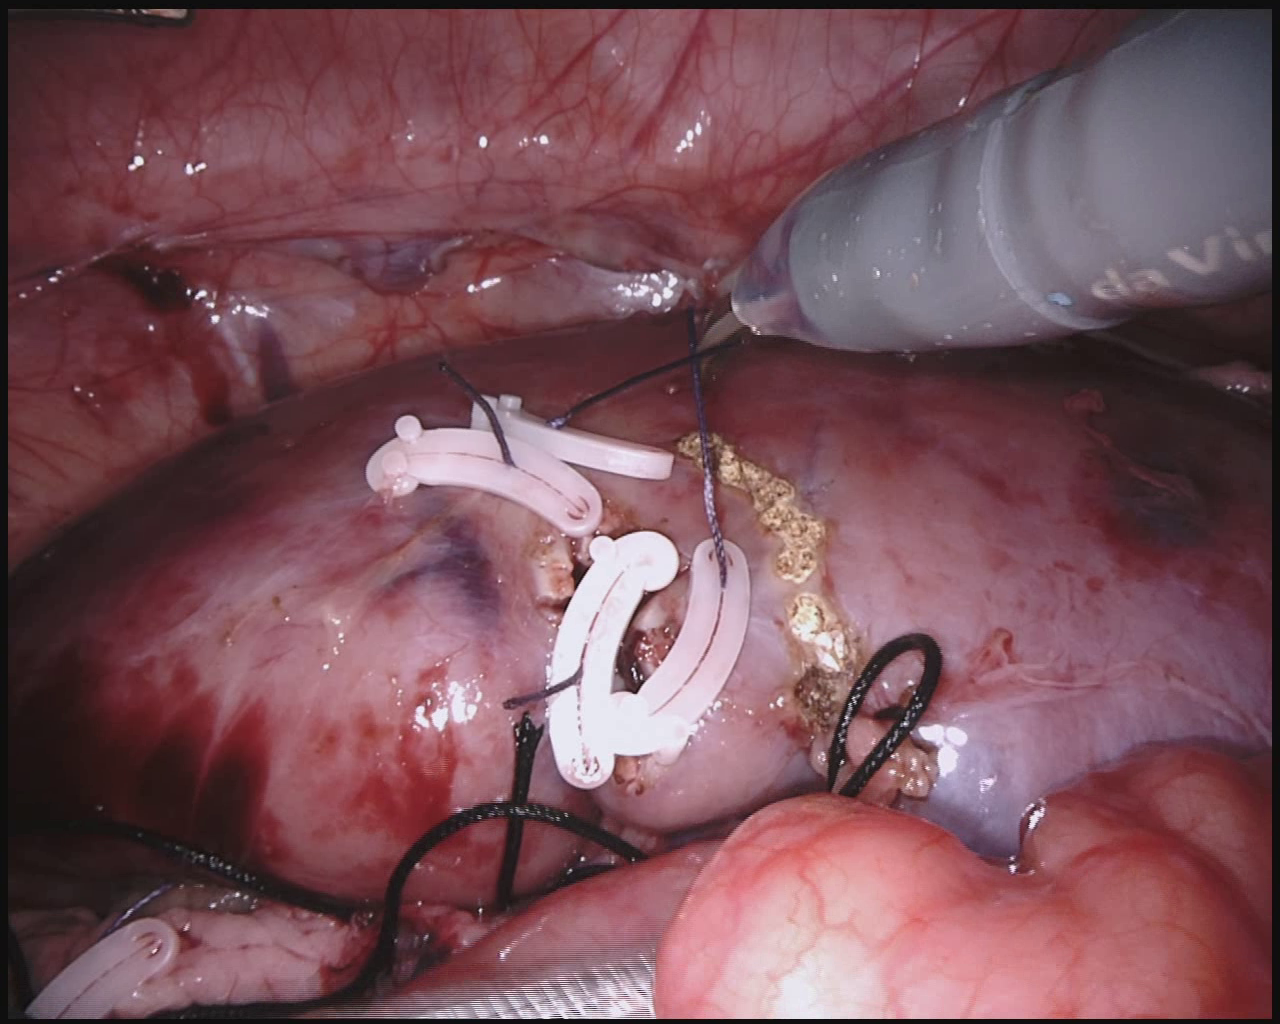

In [33]:
image = Image.open('/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/left_frames/frame060.png')
image


In [34]:
# prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [35]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [36]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 11, 128, 128])


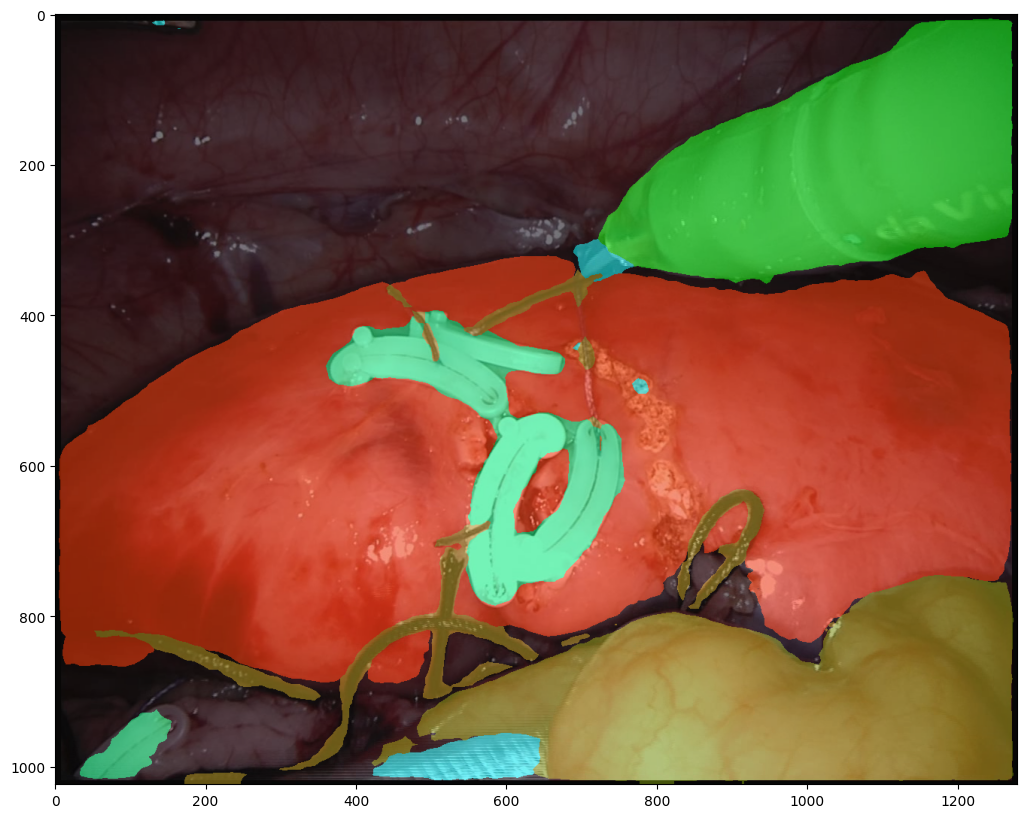

In [37]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[seg == label, :] = color

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

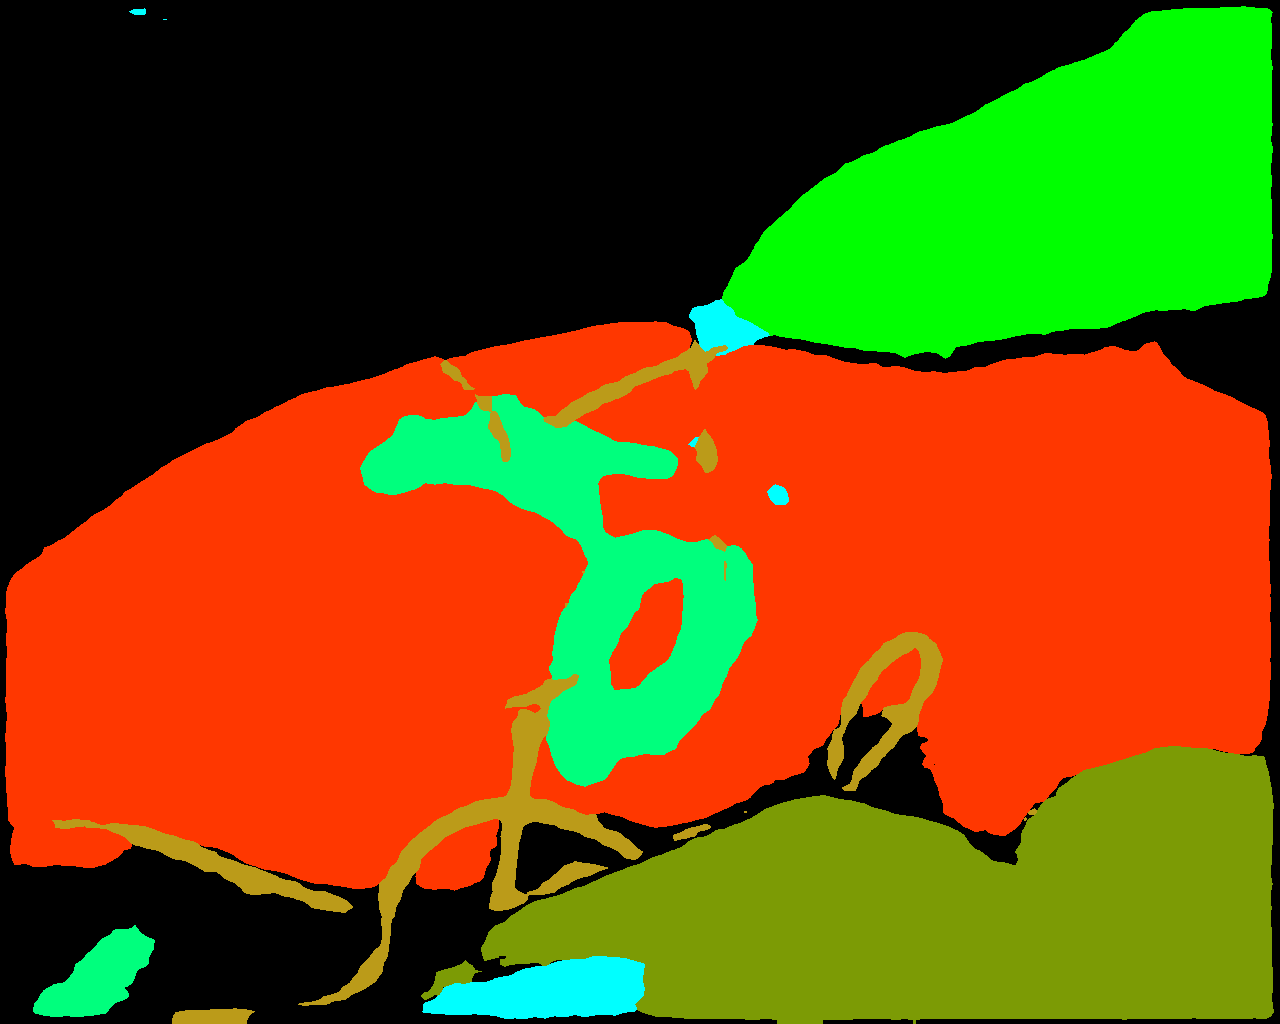

In [38]:
Image.fromarray(color_seg)

# Compare with the original dataset

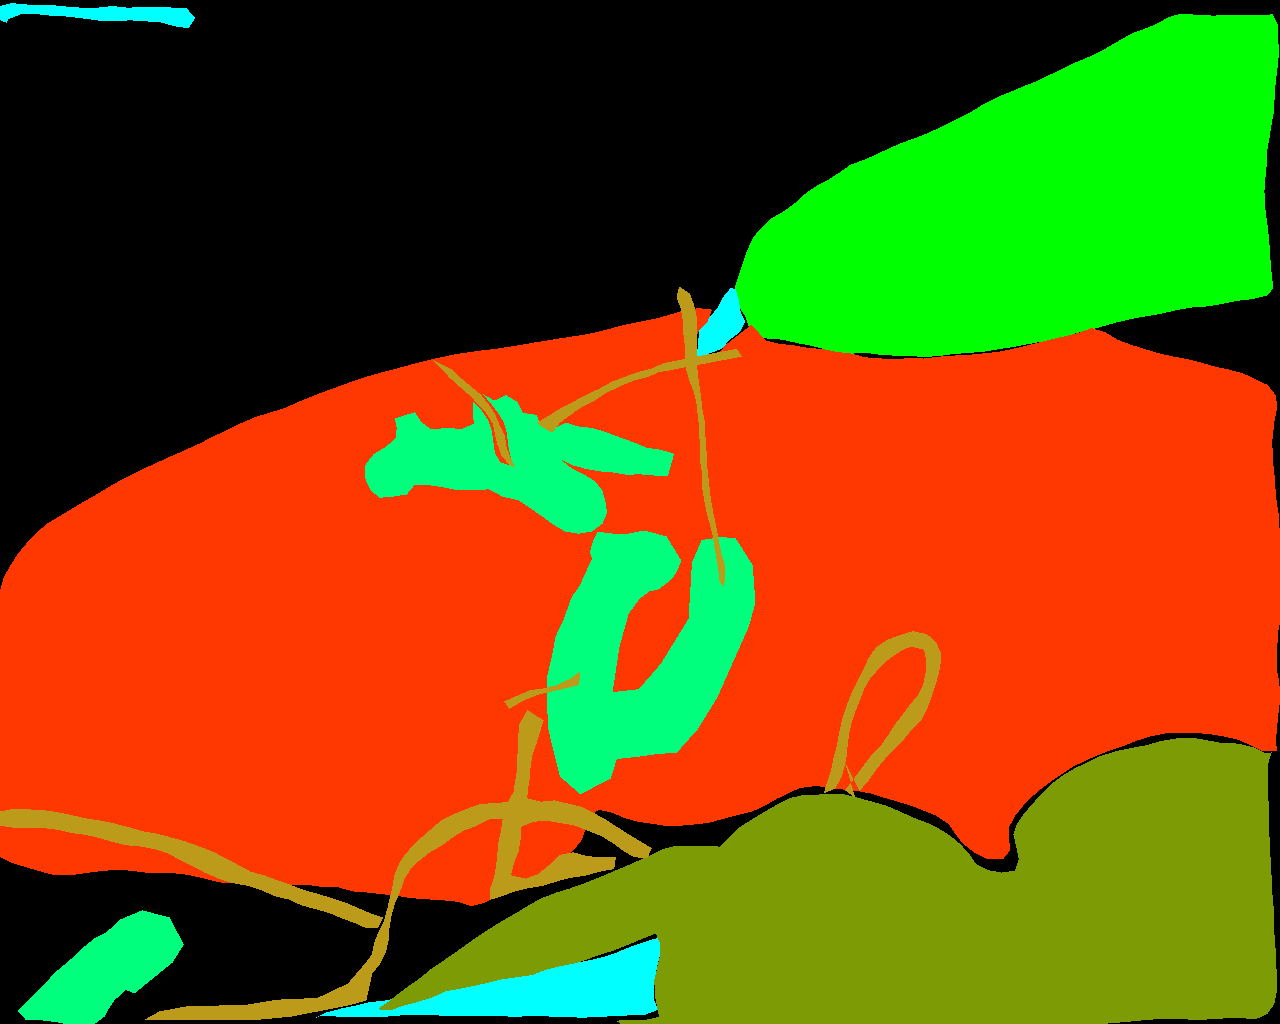

In [39]:
map = Image.open('/content/gdrive/MyDrive/miccai_challenge_2018_release_1/seq_1/labels/frame060.png')
map